In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from datetime import datetime

from threading import Thread
import IPython
import IPython.display

import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import LSTM, LeakyReLU ,Flatten , Dense,Dropout
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

import matplotlib.pyplot as plt
from profiling import cumTimer , simple_timer

In [3]:
print(tf.__version__)

2.6.0


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
tf.test.is_built_with_cuda()

3 Physical GPUs, 3 Logical GPUs


True

# Import Data

In [5]:
InputData = np.genfromtxt('Data/InputData1.csv',delimiter=",")
t = np.genfromtxt('Data/time1.csv',delimiter=",")
Data = np.genfromtxt('Data/OutputData1.csv',delimiter=",")
print(f"OutData: %s, \nInputData: %s, \nTime: %s" %(np.shape(Data),np.shape(InputData),np.shape(t)))

OutData: (400, 28), 
InputData: (28, 6), 
Time: (400,)


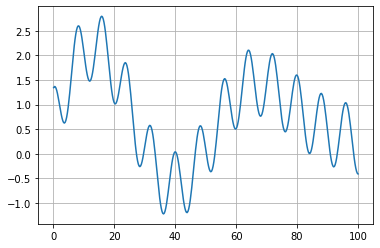

In [6]:
example_ind = 3
plt.plot(t,Data[:,example_ind])
plt.grid()

# Split The Data

You'll use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons:

    It ensures that chopping the data into windows of consecutive samples is still possible.
    It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.


In [7]:
n = Data.shape[1]
train_df = Data[:, 0:int(n*0.7):]
val_df = Data[:,int(n*0.7):int(n*0.9):]
test_df = Data[:,int(n*0.9):]

num_features = Data.shape[1]


# Normalize Data

In [8]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

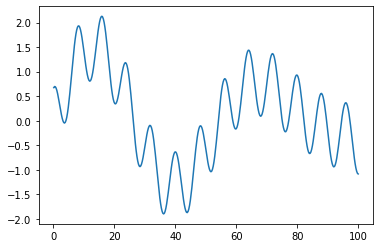

In [9]:
plt.plot(t,train_df[:,example_ind])


# Data Windowing

In [10]:
from window import WindowGenerator

Total window size: 60
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]

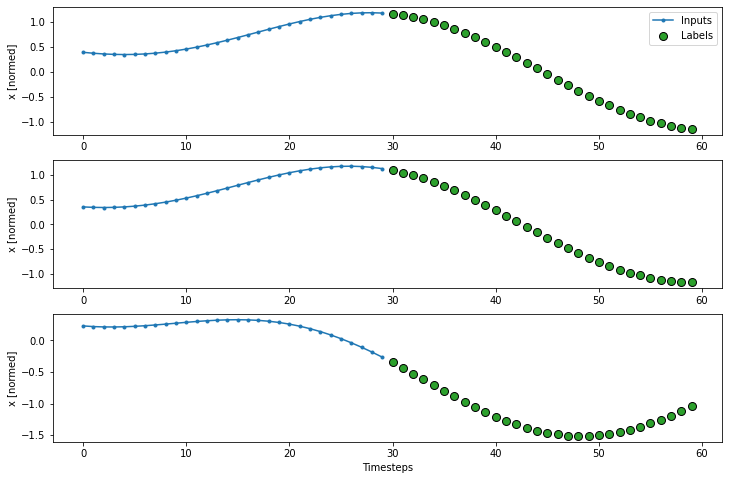

In [11]:
OUT_STEPS = 30
multi_window = WindowGenerator(input_width=30,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               train_df=train_df,
                               val_df=val_df,
                               test_df=test_df,
                               batch_size = 1000)

multi_window.plotexample()
multi_window

# FeedBack Model

In [12]:
from network import FeedBack

In [13]:
feedback_model = FeedBack(units=64, out_steps=OUT_STEPS)

# Observe Shapes

In [14]:
prediction, *states = feedback_model.warmup(multi_window.example[0])
print('Input shape:', multi_window.example[0].shape)
print('Prediction shape:', prediction.shape)

Input shape: (1000, 30, 1)
Prediction shape: (1000, 1)


## Output Shape

In [15]:
%%time
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0])[0].shape)

Output shape (batch, time, features):  (1000, 30, 1)
CPU times: user 186 ms, sys: 3.48 ms, total: 190 ms
Wall time: 177 ms


## Plot Example

TypeError: tuple indices must be integers or slices, not tuple

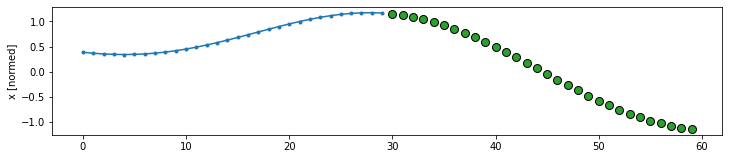

In [16]:
multi_window.plotexample(feedback_model)

## Plot Specific

/usr/local/lib64/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


ValueError: x and y must be the same size

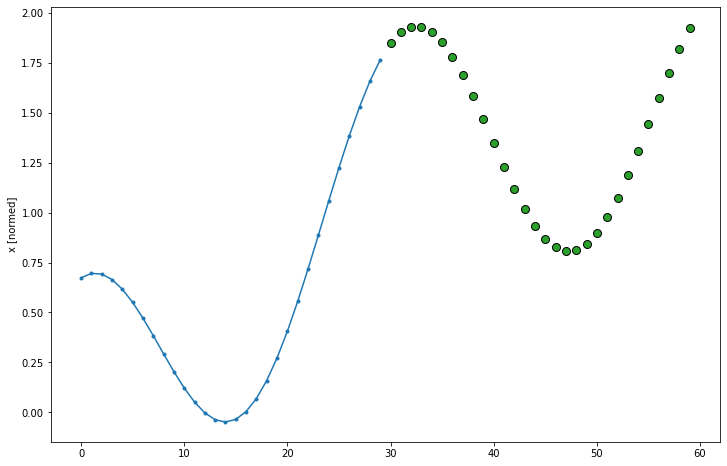

In [17]:
multi_window.plotCase(train_df[:,3],t,feedback_model)

# Compile And Fit Model

In [18]:
def compile_and_fit(model, name, window, patience=10, MAX_EPOCHS=500, record=False, load=None):
    now = datetime.now()
    dt_string = now.strftime("%d-%m-%Y-%H:%M")
    if load is not None:
        model.load_weights(f"Models/{load}")
        NAME = load + "AR@"+str(MAX_EPOCHS)+dt_string
    else:
        NAME = name + "@"+str(MAX_EPOCHS)+"@"+dt_string

    filename = os.path.join("Models",  NAME + '.h5')

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')
    if record == True:
        tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
        checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=0,
                                     save_best_only=True, mode='min', save_weights_only=True)
        callbacks = [early_stopping, tensorboard, checkpoint]
    else:
        callbacks = [early_stopping]

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        batch_size=16,
                        callbacks=callbacks)
    return history


val_performance = {}
performance = {}


In [19]:
multi_val_performance = {}
multi_performance = {}

In [20]:
feedback_model.summary()

Model: "feed_back"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM1 (LSTM)                 multiple                  16896     
_________________________________________________________________
LSTM2 (LSTM)                 multiple                  33024     
_________________________________________________________________
Flat (Flatten)               multiple                  0         
_________________________________________________________________
Dense1 (Dense)               multiple                  122944    
_________________________________________________________________
Output (Dense)               multiple                  65        
Total params: 172,929
Trainable params: 172,929
Non-trainable params: 0
_________________________________________________________________


In [22]:
%%time
mirrored_strategy = tf.distribute.MirroredStrategy()
with mirrored_strategy.scope():
    feedback_model = FeedBack(units=101, out_steps=OUT_STEPS)
    feedback_model(multi_window.example[0])
    history = compile_and_fit(feedback_model,
                            name="LSTM_AR100_Dropout",
                            window =multi_window, 
                            patience =20, 
                            MAX_EPOCHS=50,
                            record = True,
                            load = "BenchmarkLSTM@800@20-01-2022-18:40.h5"
                            )

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)



3/3 [==============================] - 1s 98ms/step - loss: 0.5032 - mean_absolute_error: 0.5565
CPU times: user 8min 49s, sys: 47.9 s, total: 9min 37s
Wall time: 6min 54s


# Visualize Results

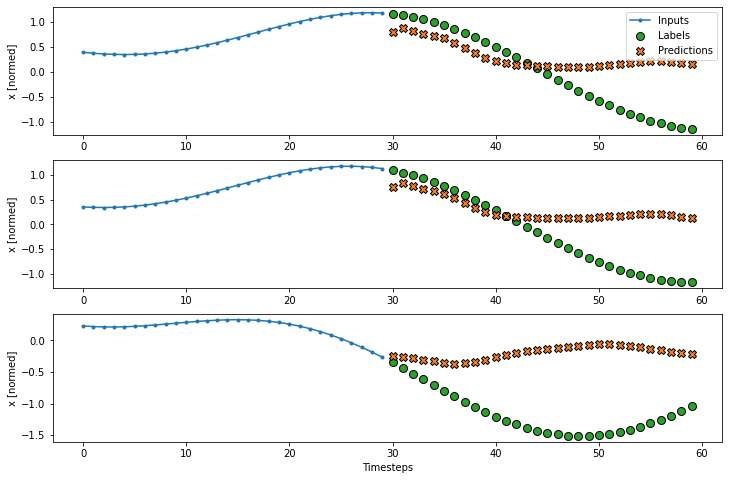

In [23]:
multi_window.plotexample(feedback_model)

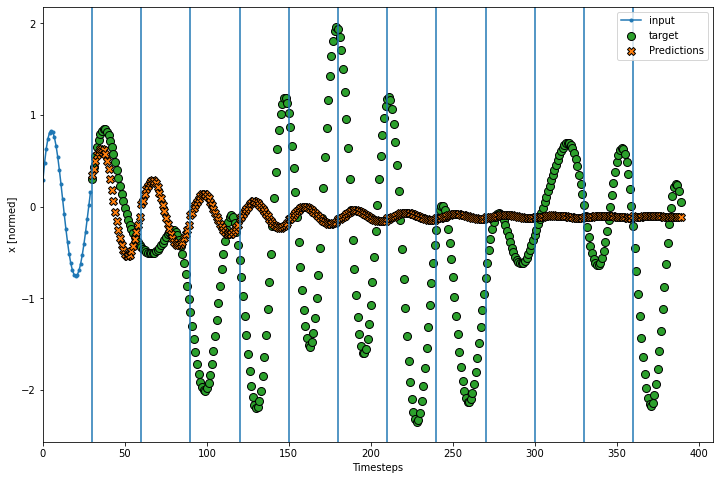

In [40]:
startTime = 250
exampleCase = 1
CaseParameters = InputData[exampleCase]
# print("W: {}\nZ: {}\nX0: {}\nV0: {}".format(*CaseParameters))
pred = multi_window.plotCase( data=val_df[:, exampleCase],timesteps= t, model=feedback_model)

In [41]:
feedback_model.save_weights("Models/BenchmarkAR.h5")